# Stochastic Models in Finance: TP4
By: 
- Adonis JAMAL
- Ayoub EL KBADI
- Fotios KAPOTOS

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.sparse import diags
from scipy.linalg import solve_banded
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [ ]:
# Model values
S0 = 100    # initial stock price
K = 100     # strike price
T = 1.0     # time to maturity in years
r = 0.05    # risk-free rate
sigma = 0.2 # volatility
d = 12      # number of observations
N = 100     # number of spatial steps
M = 100     # number of time steps

## TP Question IV.1

1. Prix EDP du call européen et comparaison avec la formule de Black-Scholes

In [3]:
def black_scholes_call_price(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T) + 1e-10)
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def pde_price_implicit(S0, K, T, r, sigma, M, N, L_factor=4):
    """
    Solves the Black-Scholes PDE using the implicit Euler method.

    Args:
        M (int): number of time steps
        N (int): number of spatial steps
        L_factor (float, optional): Factor to extend the grid. Defaults to 4.
    """
    dt = T / M

    # Spatial grid
    y_min = np.log(K) - L_factor * sigma * np.sqrt(T)
    y_max = np.log(K) + L_factor * sigma * np.sqrt(T)
    h = (y_max - y_min) / N
    y_grid = np.linspace(y_min, y_max, N + 1)
    S_grid = np.exp(y_grid)

    # Initial condition
    U = np.maximum(S_grid - K, 0)

    # PDE coefficients to construct tridiagonal matrix
    alpha = dt * (- sigma**2 / (2 * h**2) + (r - 0.5 * sigma**2) / (2 * h))
    beta = 1 + dt * (sigma**2 / h**2 + r)
    gamma = dt * (- sigma**2 / (2 * h**2) - (r - 0.5 * sigma**2) / (2 * h))

    # Construct the matrix for interior points i=1 to N-1
    d_main = np.full(N - 1, beta)
    d_lower = np.full(N - 1, alpha)
    d_upper = np.full(N - 1, gamma)

    # We use this format for the imported solve_banded function
    ab = np.zeros((3, N - 1))
    ab[0, 1:] = d_upper[:-1]  # upper diagonal
    ab[1, :] = d_main         # main diagonal
    ab[2, :-1] = d_lower[1:]  # lower diagonal

    # Time stepping
    for j in range(M):
        U_prev = U[1:N]

        # Limit conditions
        # y -> -inf, Call -> 0
        bc_lower = 0
        # y -> +inf, Call -> S - K * exp(-r * tau)
        tau_next = (j + 1) * dt
        bc_upper = np.exp(y_grid[N]) - K * np.exp(-r * tau_next)

        # Adjust the vector for boundary conditions
        b = U_prev.copy()
        b[0] -= alpha * bc_lower
        b[-1] -= gamma * bc_upper

        # Solve and update the solution
        U_inner = solve_banded((1, 1), ab, b)
        U[1:N] = U_inner
        U[0] = bc_lower
        U[N] = bc_upper
    
    return S_grid, U

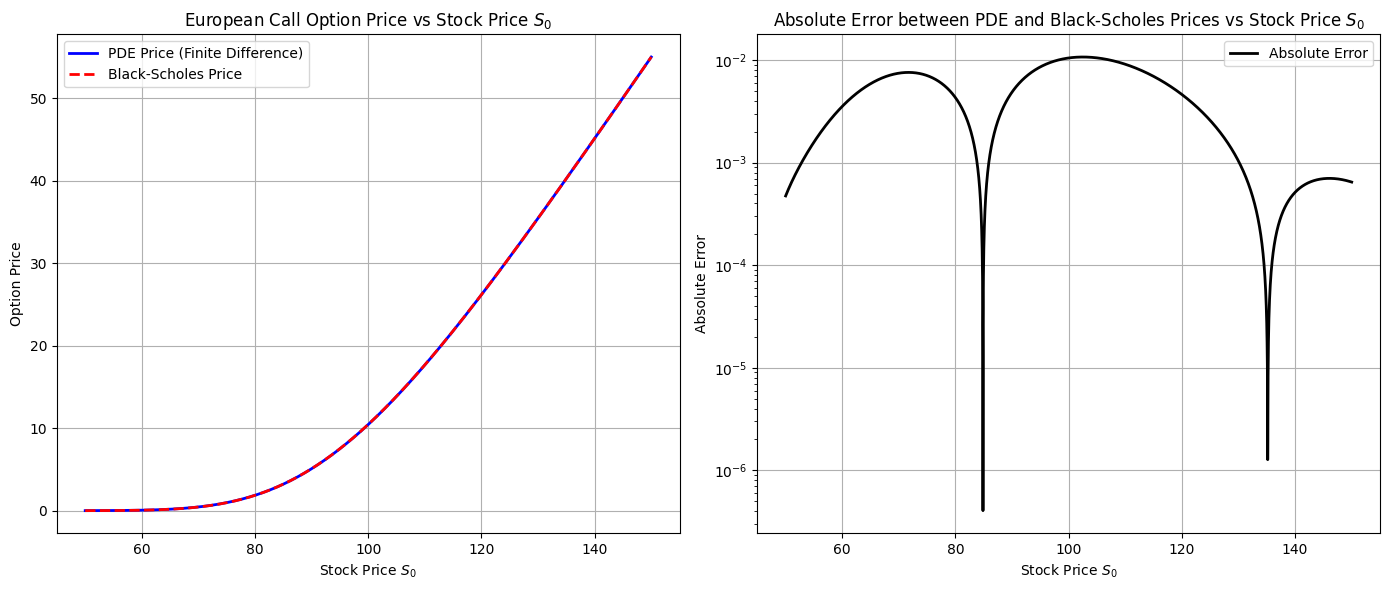

In [4]:
s_pde, price_pde = pde_price_implicit(S0, K, T, r, sigma, M, N)
price_bs = black_scholes_call_price(s_pde, K, T, r, sigma)

mask = (s_pde >= 0.5 * K) & (s_pde <= 1.5 * K)

# Plot
plt.figure(figsize=(14, 6))

# PDE Price vs S0
plt.subplot(1, 2, 1)
plt.plot(s_pde[mask], price_pde[mask], 'b-', label='PDE Price (Finite Difference)', linewidth=2)
plt.plot(s_pde[mask], price_bs[mask], 'r--', label='Black-Scholes Price', linewidth=2)
plt.title('European Call Option Price vs Stock Price $S_0$')
plt.xlabel('Stock Price $S_0$')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)

# Error plot
plt.subplot(1, 2, 2)
error = np.abs(price_pde - price_bs)
plt.plot(s_pde[mask], error[mask], 'k-', label='Absolute Error', linewidth=2)
plt.title('Absolute Error between PDE and Black-Scholes Prices vs Stock Price $S_0$')
plt.xlabel('Stock Price $S_0$')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True)
plt.yscale('log')

plt.tight_layout()
plt.show()

On observe que le prix obtenu par la méthode des différences finies implicites est très proche de celui obtenu par la formule de Black-Scholes, avec une erreur négligeable.

Cette erreur est plus importante autour du strike ($S_0 \approx K=100$), ce qui est attendu car la condition initiale (payoff $(S - K)_+$) n'est pas dérivable en ce point $K$, ce qui réduit la précision de la méthode numérique.

2. Erreur en norme infinie du vecteur de prix EDP en fonction de $N$

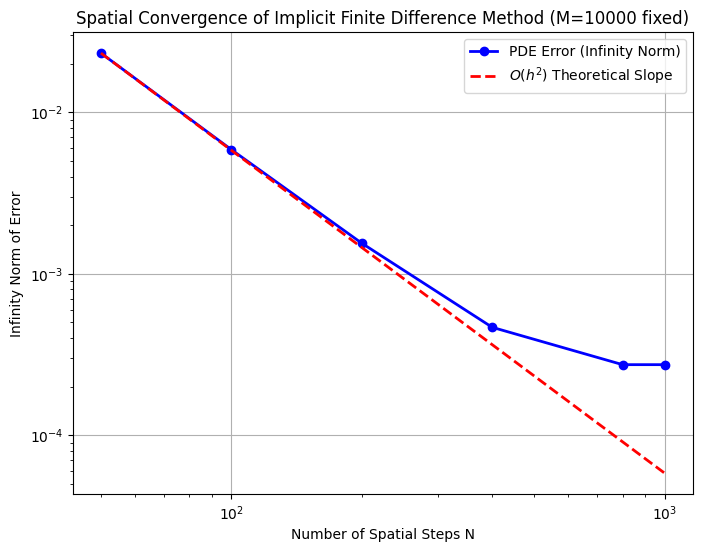

Estimated spatial convergence rate: -1.51


In [5]:
# Fix large M and vary N to study spatial error
M_fixed = 10**4
N_values = [50, 100, 200, 400, 800, 1000]

errors_spatial = []
h_values = []

for N in N_values:
    # Solve PDE and compute Black-Scholes price
    s_pde, price_pde = pde_price_implicit(S0, K, T, r, sigma, M_fixed, N)
    price_bs = black_scholes_call_price(s_pde, K, T, r, sigma)
    
    # Compute infinity norm of the error
    error_inf = np.max(np.abs(price_pde - price_bs))
    errors_spatial.append(error_inf)

# Plot
plt.figure(figsize=(8, 6))

# Log-Log plot of spatial error
plt.loglog(N_values, errors_spatial, 'bo-', label='PDE Error (Infinity Norm)', linewidth=2)

# Reference line for O(h^2)
ref_order_2 = [errors_spatial[0] * (N_values[0] / N)**2 for N in N_values]
plt.loglog(N_values, ref_order_2, 'r--', label='$O(h^2)$ Theoretical Slope', linewidth=2)

plt.title(f'Spatial Convergence of Implicit Finite Difference Method (M={M_fixed} fixed)')
plt.xlabel('Number of Spatial Steps N')
plt.ylabel('Infinity Norm of Error')
plt.legend()
plt.grid(True)
plt.show()

# Compute slope
slope, intercept = np.polyfit(np.log(N_values), np.log(errors_spatial), 1)
print(f"Estimated spatial convergence rate: {slope:.2f}")

Théoriquement, la méthode des différences finies implicites pour l'équation de Black-Scholes est d'ordre 2 en espace, donc on s'attend à une erreur en norme infinie qui diminue comme $O(1/N^2)$ lorsque $N$ augmente. Sur le graphique log-log ci-dessus, cela se traduit par une droite de pente -2.

$M$ est fixé à 10000 pour minimiser l'erreur temporelle et se concentrer sur l'erreur spatiale. On observe que, quand $N$ reste petit relativement à $M$, les points expérimentaux suivent une tendance linéaire avec une pente proche de -2, confirmant l'ordre 2 en espace. Cependant, plus $N$ augmente, la pente augmente, indiquant que l'erreur ne diminue plus comme $O(1/N^2)$. Cela est dû au fait que l'erreur temporelle devient dominante tandis que l'erreur spatiale diminue.

L'erreur totale plafonne donc sur la valeur de l'erreur temporelle, expliquant la saturation observée pour les grandes valeurs de $N$.

Par ailleurs, le payoff $(S - K)_+$ n'étant pas dérivable en $K$, la précision de la méthode est réduite, ce qui peut aussi contribuer à la perturbation de la convergence.

3. Erreur en norme infinie du vecteur de prix EDP en fonction de $M$

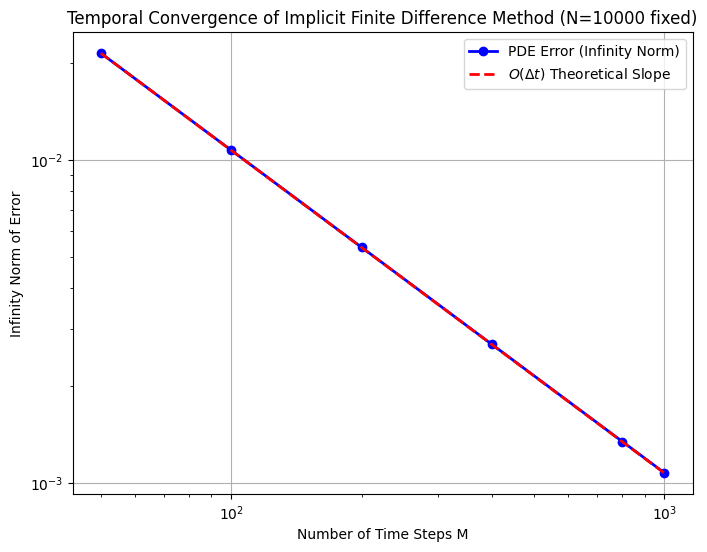

Estimated temporal convergence rate: -1.00


In [6]:
N_fixed = 10**4
M_values = [50, 100, 200, 400, 800, 1000]

errors_temporal = []
dt_values = []

for M in M_values:
    # Solve PDE and compute Black-Scholes price
    s_pde, price_pde = pde_price_implicit(S0, K, T, r, sigma, M, N_fixed)
    price_bs = black_scholes_call_price(s_pde, K, T, r, sigma)
    
    # Compute infinity norm of the error
    error_inf = np.max(np.abs(price_pde - price_bs))
    errors_temporal.append(error_inf)
    dt_values.append(T / M)

# Plot
plt.figure(figsize=(8, 6))

# Log-Log plot of temporal error
plt.loglog(M_values, errors_temporal, 'bo-', label='PDE Error (Infinity Norm)', linewidth=2)

# Reference line for O(dt)
ref_order_1 = [errors_temporal[0] * (M_values[0] / M) for M in M_values]
plt.loglog(M_values, ref_order_1, 'r--', label='$O(\Delta t)$ Theoretical Slope', linewidth=2)

plt.title(f'Temporal Convergence of Implicit Finite Difference Method (N={N_fixed} fixed)')
plt.xlabel('Number of Time Steps M')
plt.ylabel('Infinity Norm of Error')
plt.legend()
plt.grid(True)
plt.show()

# Compute slope
slope, intercept = np.polyfit(np.log(M_values), np.log(errors_temporal), 1)
print(f"Estimated temporal convergence rate: {slope:.2f}")


Cette fois, $N$ est fixé à 10000 pour minimiser l'erreur spatiale et se concentrer sur l'erreur temporelle. On observe que les points expérimentaux suivent une tendance linéaire avec une pente extrêmement proche de -1, confirmant que la méthode est d'ordre 1 en temps.

Le payoff $(S - K)_+$ pose moins de problème pour la convergence temporelle que spatiale.

4. Erreur ponctuelle $|u_i^j - u(j\Delta T, y_i)|$ en fonction de $t = T - j \Delta T \in [0, T]$ et $S = e^{y_i} \in [e^{-L}, e^{L}]$

In [7]:
# We modify the pde_price_implicit function to return the full solution grid
def pde_price_implicit_full(S0, K, T, r, sigma, M, N, L_factor=4):
    dt = T / M

    # Spatial grid
    y_min = np.log(K) - L_factor * sigma * np.sqrt(T)
    y_max = np.log(K) + L_factor * sigma * np.sqrt(T)
    h = (y_max - y_min) / N
    y_grid = np.linspace(y_min, y_max, N + 1)
    S_grid = np.exp(y_grid)

    # History array
    U_history = np.zeros((M + 1, N + 1))

    # Initial condition
    U = np.maximum(S_grid - K, 0)
    U_history[0, :] = U.copy()

    # PDE coefficients to construct tridiagonal matrix
    alpha = dt * (- sigma**2 / (2 * h**2) + (r - 0.5 * sigma**2) / (2 * h))
    beta = 1 + dt * (sigma**2 / h**2 + r)
    gamma = dt * (- sigma**2 / (2 * h**2) - (r - 0.5 * sigma**2) / (2 * h))

    # Construct the matrix for interior points i=1 to N-1
    d_main = np.full(N - 1, beta)
    d_lower = np.full(N - 1, alpha)
    d_upper = np.full(N - 1, gamma)

    # We use this format for the imported solve_banded function
    ab = np.zeros((3, N - 1))
    ab[0, 1:] = d_upper[:-1]  # upper diagonal
    ab[1, :] = d_main         # main diagonal
    ab[2, :-1] = d_lower[1:]  # lower diagonal

    # Time stepping
    for j in range(M):
        U_prev = U[1:N]
        tau_next = (j + 1) * dt

        bc_lower = 0
        bc_upper = np.exp(y_grid[N]) - K * np.exp(-r * tau_next)

        b = U_prev.copy()
        b[0] -= alpha * bc_lower
        b[-1] -= gamma * bc_upper

        U_inner = solve_banded((1, 1), ab, b)
        U[1:N] = U_inner
        U[0] = bc_lower
        U[N] = bc_upper

        U_history[j + 1, :] = U.copy()

    tau_vals = np.linspace(0, T, M + 1)
    t_vals = T - tau_vals
    return S_grid, t_vals, U_history

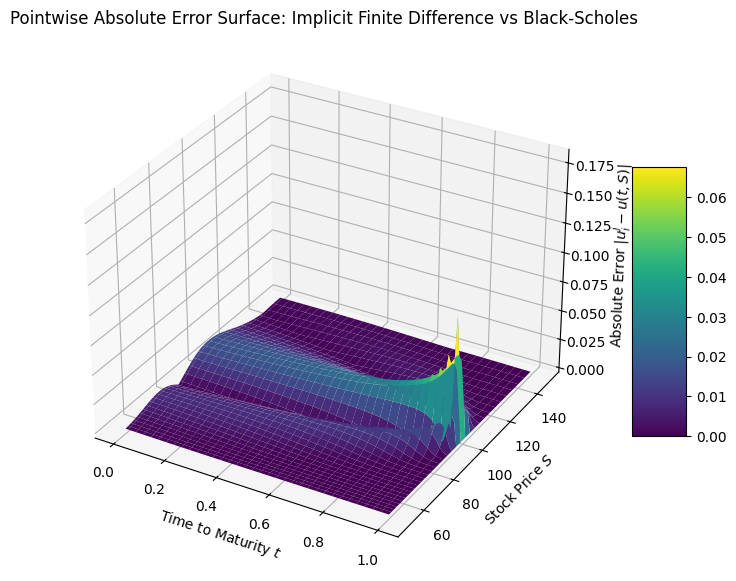

In [8]:
M_plot = 100
N_plot = 100

# Generate full solution surface
S_vec, t_vec, U_surf = pde_price_implicit_full(S0, K, T, r, sigma, M_plot, N_plot)

# 
tau_vec = T - t_vec
S_mesh, Tau_mesh = np.meshgrid(S_vec, tau_vec)

exact_surface = np.zeros_like(U_surf)

for i, tau in enumerate(tau_vec):
    if tau == 0:
        exact_surface[i, :] = np.maximum(S_vec - K, 0)
    else:
        exact_surface[i, :] = black_scholes_call_price(S_vec, K, tau, r, sigma)

error_surface = np.abs(U_surf - exact_surface)

# 3D Surface Error Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

mask = (S_vec > 50) & (S_vec < 150)
S_plot = S_mesh[:, mask]
T_plot = T - Tau_mesh[:, mask]
Error_plot = error_surface[:, mask]

surf = ax.plot_surface(T_plot, S_plot, Error_plot, cmap=cm.viridis)
ax.set_xlabel('Time to Maturity $t$')
ax.set_ylabel('Stock Price $S$')
ax.set_zlabel('Absolute Error $|u_i^j - u(t, S)|$')
ax.set_title('Pointwise Absolute Error Surface: Implicit Finite Difference vs Black-Scholes')

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


Le graphique ci-dessus montre l'erreur ponctuelle entre la solution numérique $u_i^j$ obtenue par la méthode des différences finies implicites et la solution analytique $u(t, S)$ donnée par la formule de Black-Scholes, en fonction du temps $t = T - j \Delta T$ et du prix de l'actif sous-jacent $S = e^{y_i}$.

On remarque que le pic d'erreur se situe à $t=1$ (Maturité) et autour du strike $S=K=100$. Cela est cohérent avec le fait que la condition initiale (payoff $(S - K)_+$) n'est pas dérivable en $K$, ce qui engendre une plus grande erreur numérique près de ce point. 

De plus, l'erreur diminue à mesure que l'on s'éloigne de la maturité, car la solution devient plus lisse. En effet, l'EDP de Black-Scholesest une équation parabolique (diffusion), et la diffusion tend à lisser les irrégularités au fil du temps. 

## TP Question IV.2 (facultatif)

1. Deep Galerkin pour l'EDP de Black-Scholes

2. Prix en norme infinie du vecteur de prix EDP

3. Erreur ponctuelle $|u_i^j - u(j\Delta T, y_i)|$ en fonction de $t = T - j \Delta T$ et $S = e^{y_i}$

Questions ouvertes:
- Analyser la convergence de la méthode
- Tester la sensibilité aux paramètres
- Tester la faisabilité en grande dimension